In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import requests
from scipy import stats
import seaborn as sns

# 0. Loading the data

In [2]:
#load data/moviesummaries/character.metadata.tsv
character_metadata = pd.read_csv('../data/moviesummaries/character.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/plot_summaries.txt
plot_summaries = pd.read_csv('../data/moviesummaries/plot_summaries.txt', sep='\t', header=None)

#load data/moviesummaries/movie.metadata.tsv
movie_metadata = pd.read_csv('../data/moviesummaries/movie.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/name.clusters.txt
name_clusters = pd.read_csv('../data/moviesummaries/name.clusters.txt', sep='\t', header=None)


In [3]:
# Rename columns of each dataset to match documentation
character_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", 
                              "Actor height", "Actor ethnicity", "Actor name", "Actor age", "Freebase character/actor map ID", 
                              "Freebase character ID", "Freebase actor ID"]

plot_summaries.columns = ["Wikipedia movie ID", "Summary"]

movie_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie revenue", "Movie runtime",
                          "Movie languages", "Movie countries", "Movie genres"]

name_clusters.columns = ["Character name", "Freebase character/actor map ID"]

We get 4 different dataframes; we'll merge movie_metadata and plot_summaries together since it makes sense to get the plot information directly linked with the movie metadata, and keep the others as is.

# 1. Preprocessing plot and metadata about movies

We can see from the columns name that we can simply add the plot summaries of the movies to the movie metadata dataframe. Let's first take a look at how many data we have in each dataset :

In [4]:
# Print the size of plot and meta_data dataset
print("Number of data in the metadata dataframe :", movie_metadata.shape[0])
print("Number of data in the plot summaries dataframe :", plot_summaries.shape[0])

Number of data in the metadata dataframe : 81741
Number of data in the plot summaries dataframe : 42303


We can see that approximately half of the movies in the metadata have a plot description. Let's first check if 'Wikipedia movie ID' can be used as a unique key to merge the two dataframes :

In [5]:
# Find out how many duplicates there are in the datasets
print("Numbers of duplicated Wikipedia movie ID in the metadata dataframe : ", movie_metadata["Wikipedia movie ID"].duplicated().sum())
print("Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe : ", plot_summaries["Wikipedia movie ID"].duplicated().sum())

Numbers of duplicated Wikipedia movie ID in the metadata dataframe :  0
Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe :  0


We can see that there are no duplicates in the Wikipedia movie ID column, so we can use it as a unique key to merge the two dataframes. Let's do it; We merge the two dataframes 'left' on the Wikipedia movie ID column, so that we keep all the movies in the metadata dataframe, even those that doesn't have a plot description.

In [6]:
# Merge 'left' the movie_metadata and plot_summaries dataframes on the Wikipedia movie ID column
all_movies = movie_metadata.merge(plot_summaries, on="Wikipedia movie ID", how="left")
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [7]:
# Check the number and percentage of null values in each column of plot_summaries as well as the number of different values in each column.
all_movies_null = pd.DataFrame(all_movies.isnull().sum(), columns=['Number of null values'])
all_movies_null['Percentage of null values'] = all_movies_null['Number of null values'] / len(all_movies)
all_movies_null['Number of unique values'] = all_movies.nunique()

print(all_movies.shape)
all_movies_null


(81741, 10)


,Number of null values,Percentage of null values,Number of unique values
Wikipedia movie ID,0,0.000000,81741
Freebase movie ID,0,0.000000,81741
Movie name,0,0.000000,75478
Movie release date,6902,0.084437,20389
Movie revenue,73340,0.897224,7362
Movie runtime,20450,0.250180,597
Movie languages,0,0.000000,1817
Movie countries,0,0.000000,2124
Movie genres,0,0.000000,23817
Summary,39537,0.483686,42196


As mentioned above, we see that approximately 48% percent of the movie dataset doesn't have a corresponding plot summary!

But what about dupplicated plot summaries? It's very unlikely that 2 movies have the exact same entry, but let's check that :

In [8]:
# Show plot summary duplicates which are not NaNs
duplicate_plot_movies = all_movies[all_movies.duplicated(subset=['Summary'], keep = False) & all_movies['Summary'].notnull()]

# Print number of plot summaries having at least one duplicate
print("Number of plot summaries having at least one duplicate :", duplicate_plot_movies['Summary'].nunique())

duplicate_plot_movies[['Wikipedia movie ID', 'Movie name', 'Summary']].sort_values(by=['Summary'])


Number of plot summaries having at least one duplicate : 5


,Wikipedia movie ID,Movie name,Summary
4551,14055212,The Trial of Madame X,A woman is thrown out of her home by her jealo...
18993,14022275,Madame X,A woman is thrown out of her home by her jealo...
49381,14037732,Madame X,A woman is thrown out of her home by her jealo...
57569,14051944,Madame X,A woman is thrown out of her home by her jealo...
65014,14053389,Madame X,A woman is thrown out of her home by her jealo...
28621,29481480,Drohi,An orphan Raghav turns into a ruthless contrac...
67464,25493367,Antham,An orphan Raghav turns into a ruthless contrac...
15783,14616220,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
57508,28852030,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
22185,19609453,Amar Deep,Raja was adopted by a criminal don at a very ...


We see that there are 5 different plot summaries that have at least one duplicate! In some cases, the duplicate has the same movie name but in other cases, the duplicate has a different movie name. 

Let's look at the bigger picture. We merge with character metadata to add columns which may differentiate movies. Then we will check for duplicates on all columns exept the IDs.

In [14]:
# Check for duplicates on all columns except for the ID columns
check_duplicates = all_movies[all_movies.duplicated(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], keep=False)]
duplicated_movie_names = check_duplicates["Movie name"].unique()

# filter all_movies to keep only the movies with name in duplicated_movie_names
duplicated_movies = all_movies[all_movies["Movie name"].isin(duplicated_movie_names)]

# sort by movie name
duplicated_movies.sort_values(by=["Movie name"])

Unique values of movie name :  ['Dost' 'Woman to Woman' 'Horizontal Axis' "My Wife's Family"
 "A Sister to Assist 'Er"]


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
77623,33545325,/m/0hgpm4_,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
74307,33545395,/m/0hgrll0,A Sister to Assist 'Er,NaN,NaN,64.0,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
38544,33545449,/m/0hgrdzf,A Sister to Assist 'Er,NaN,NaN,59.0,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
35927,33545359,/m/0hgm4mx,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
25277,33545423,/m/0hgnyld,A Sister to Assist 'Er,NaN,NaN,72.0,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
640,32505827,/m/0h1cbks,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
75111,32517667,/m/0h1dthj,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
34621,32524274,/m/0h1f4gk,Dost,2004-05-03,NaN,NaN,"{""/m/09s02"": ""Telugu language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}",NaN
16646,32496356,/m/0h1bj0k,Dost,1989,NaN,150.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",Sher Singh and his son Nagender are involved...
31058,10699428,/m/02qmlnp,Dost,1974,NaN,166.0,"{""/m/03k50"": ""Hindi Language"", ""/m/02hxcvy"": ""...","{""/m/03rk0"": ""India""}","{""/m/01chg"": ""Bollywood""}",Maanav is an orphan who was brought up by a Ca...


# ????
idk pourquoi ca print aussi des trucs qui sont pas duplicated en dessus, mais en tout cas y'en a des vrais donc faut en faire qqch (drop un des deux random)

We notice that those films, even though they have strictly the same plot summary, are different movies. In fact, by looking at the Wikipedia page [Madame X (disambiguation)](https://en.wikipedia.org/wiki/Madame_X_(disambiguation)), we can cleary see why that is so. Those movies are simply different versions of the same story, produced in different countries, in different years, and the plot summary is the same for all of them. Our theory is that it was simply copied from one version to the other when the Wikipedia pages were created.

 We can therefore keep them as is.

## Data cleaning

### Movie release date


Let's now take a look at the movies release dates. By looking at the data, we see 4 cases :
 - The release date is a year 
 - The release date is a month and a year 
 - The release date is a day, a month and a year 
 - The release date is not a number

Let's convert every entry to only a year when it's possible :

Defining three functions checking which format is valid for a specific string

In [11]:
# import the datetime module
import datetime

 # Function to check if a string matches the specified date format
 
 # For format 1 : YYYY-MM-DD
def valid_format1(date_string, date_format='%Y-%m-%d'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False

# For format 2 : YYYY-MM
def valid_format2(date_string, date_format='%Y-%m'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False   

# For format 3 : YYYY
def valid_format3(date_string, date_format='%Y'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False
        

Creating a function to keep only the year, if the data is in one of the three formats defined above

In [12]:
import datetime
import pandas as pd
import numpy as np

def keep_the_year(date_full, key):
    
    # Converting tyhe date full column to a dataframe, and replacing the nan with null values
    date_full = pd.DataFrame(date_full)
    date_full  = date_full.fillna(" ")
    
    # creating a dataframe with the same size as date_full, but with nan values
    date_formated = pd.DataFrame(np.nan, index=date_full.index, columns=date_full.columns) 

    # Define date formats
    format1 = '%Y-%m-%d'
    format2 = '%Y-%m'
    format3 = '%Y'

    # Iterate through the values in the datefull column, checking which format it matches, and converting it to datetime format
    for (index,i) in enumerate(date_full[key]):
        if valid_format1(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format1).date()
        elif valid_format2(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format2).date()
        elif valid_format3(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format3).date()
        
    #  Keeping only the year 
    date_year = pd.DatetimeIndex(date_formated[key]).year
    #Converting to int
    date_year = date_year.astype('Int64')
    return date_year

Converting the movie release date to keep only the year for the all_movie table :

In [13]:
# Setting out of bound values to nan
all_movies['Movie release date'][62836] = np.nan
# Calling the function
all_movies['Movie release date'] = keep_the_year(all_movies['Movie release date'], key='Movie release date')

C:\Users\colin\AppData\Local\Temp\ipykernel_20820\2584046882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies['Movie release date'][62836] = np.nan


KeyboardInterrupt: 

In [ ]:
all_movies.head(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",NaN
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",NaN
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",NaN


### Dictionnary structures

In [ ]:
# Print examples of the 'Movie countries', 'Movie genres' and 'Movie languages' columns as well as their types
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[:]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

{"/m/09c7w0": "United States of America"}
<class 'pandas.core.series.Series'>
{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}
<class 'str'>
{"/m/02h40lc": "English Language"}
<class 'str'>


We see that some columns are written as a dictionnary but saved as a string. 

Three columns are concerned by this problem:
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

Since we will not use the Freebase IDs, let's only keep the values of these dicts as lists.

In [ ]:
all_movies['Movie genres'] = [list(eval(genre).values()) for genre in all_movies['Movie genres']]
all_movies['Movie languages'] = [list(eval(genre).values()) for genre in all_movies['Movie languages']]
all_movies['Movie countries'] = [list(eval(genre).values()) for genre in all_movies['Movie countries']]
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

['United States of America']
<class 'list'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western']
<class 'list'>
['English Language']
<class 'list'>


Now, we have a proper dataframe containing metadata and plot summaries about movies: all_movies

# 2. Preprocessing characters metadata

In [ ]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
153984,12190326,/m/02vt_mx,2000,Roy Mason,1968-05-20,M,1.830,NaN,Timothy Olyphant,31.0,/m/03jrvbh,/m/0gxrkm9,/m/05ml_s
377800,4727,/m/01hpp,1966-07-30,Riddler,1933-04-05,M,NaN,NaN,Frank Gorshin,33.0,/m/0jv266,/m/01td26,/m/03fpfm
309826,5305725,/m/0ddmvz,NaN,NaN,1915-09-12,M,NaN,NaN,Paul Marion,NaN,/m/0j3lcm0,NaN,/m/0gffhw4
249529,19174305,/m/0416g9w,2008-09-05,NaN,NaN,F,NaN,NaN,Rasika Dugal,NaN,/m/0gcg3th,NaN,/m/0gb_f1w
399722,5814242,/m/0f6r2c,1997,NaN,1984-06-13,M,NaN,NaN,Phillip Van Dyke,12.0,/m/02vcf0y,NaN,/m/025ydcy
306808,36068268,/m/0jztrjh,2012-09-07,NaN,NaN,M,NaN,/m/0cqgdq,Bharat Jadhav,NaN,/m/0mzk5sf,NaN,/m/0266qjv
430950,5107366,/m/0d2zml,2003,NaN,NaN,M,NaN,NaN,Collin Stark,NaN,/m/0k3mqh,NaN,/m/0k3mp1
180956,9150668,/m/027zh7z,1974-02-06,NaN,1928-11-16,M,NaN,NaN,Clu Gulager,45.0,/m/02vblqm,NaN,/m/05lc_v
380739,4738411,/m/0ckr7s,1993-12-05,Darien - Tuxedo Mask,1972-12-06,M,510.000,NaN,Vince Corazza,20.0,/m/0bmz820,/m/0lyzygr,/m/08hqh0
212976,29836776,/m/0fq1tqv,1978,Nelson Fisher,1926-02-11,M,1.854,/m/0cnvdq1,Leslie Nielsen,51.0,/m/0gw3jwb,/m/0h1rzvm,/m/0fb7c


Taking a quick look, we see that we encounter the same problem with the "Movie release date" and the "Actor date of birth" columns as seen before. Let's convert every entry to only a year when it's possible :

In [ ]:
# Setting out of bound value to nan
character_metadata['Movie release date'][67624:67639] = np.nan
# Calling the function
character_metadata['Movie release date'] = keep_the_year(character_metadata['Movie release date'], key='Movie release date')

C:\Users\colin\AppData\Local\Temp\ipykernel_24556\1576258549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  character_metadata['Movie release date'][67624:67639] = np.nan


## For the actor date of birth, too many out of bounds values, is it really usefull to convert it since we already have their age ?

In [ ]:
#character_metadata['Actor date of birth'][11550] = np.nan
#character_metadata['Actor date of birth'][39427] = np.nan
#character_metadata['Actor date of birth'][42283] = np.nan
#character_metadata['Actor date of birth'][45080] = np.nan
#character_metadata['Actor date of birth'][80339] = np.nan
#character_metadata['Actor date of birth'] = keep_the_year(character_metadata['Actor date of birth'], key='Actor date of birth')

In [ ]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
33184,28429079,/m/0crfqmt,2011,Nanette,1932-12-07,F,1.70,/m/033tf_,Ellen Burstyn,78.0,/m/0dkdxnq,/m/0h5jbly,/m/019f2f
64138,24640712,/m/080kkcx,1999,Arthur Gold,1934,M,NaN,NaN,Bob Dishy,65.0,/m/04j32mt,/m/0chb5wh,/m/02pqmj
198518,5177130,/m/0d6d9f,1977,Sunder,1945-02-15,M,1.70,/m/0dryh9k,Randhir Kapoor,31.0,/m/02vd8vj,/m/0h73gtb,/m/09zf1p
215483,7818764,/m/026f3ck,1934,NaN,1894-01-03,F,1.68,NaN,ZaSu Pitts,NaN,/m/03jqlkc,NaN,/m/01lr4p
329052,14153517,/m/03cw6kv,1994,NaN,1969-12-17,F,NaN,NaN,Juliet Aubrey,24.0,/m/04ddb1r,NaN,/m/02pypy_
379819,7111027,/m/0h4p_9,2007,Bernice Graves,1945-12-01,F,1.55,/m/048z7l,Bette Midler,61.0,/m/04md6l4,/m/0glkbrl,/m/01dw9z
99697,20297825,/m/04zzpdr,1992,NaN,1912-08-04,M,NaN,NaN,David Raksin,79.0,/m/0gz07wk,NaN,/m/03m5wr
424837,14474214,/m/03d4q26,2006,Lance Valenteen,1969-05-16,M,1.85,/m/0987ctr,David Boreanaz,36.0,/m/040m7p5,/m/0gyf76t,/m/01507p
96215,6652508,/m/0gg5jd,2006,NaN,1973-01-19,M,NaN,NaN,Nash Edgerton,33.0,/m/0gdl2fk,NaN,/m/0cc8ntw
133846,30854893,/m/08b9v0,1993,NaN,1977,M,NaN,NaN,Julian Scott Urena,16.0,/m/0gc624n,NaN,/m/0cq2t5


# 3. Learning more about the data

### Chronological evolution of movie production

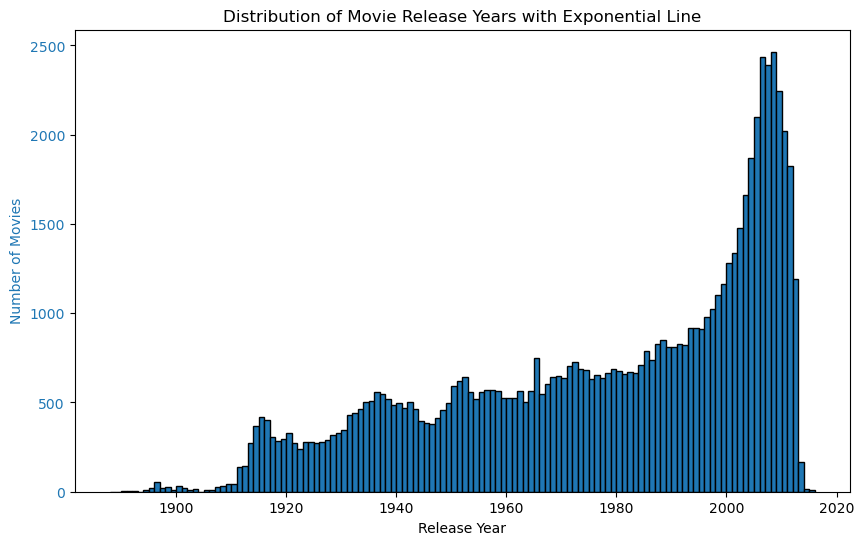

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Creating an histogram plotting the values of 'year'
ax1.hist(all_movies['Movie release date'].dropna(), bins=range(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1), edgecolor='black', label='Movie Releases')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Distribution of Movie Release Years with Exponential Line')
plt.show()

-> We have way more data for recent films

### Movie countries and genres

In [ ]:
# Print number of unique movie countries, genres and languages

unique_countries_list = all_movies['Movie countries'].explode().unique()
unique_genres_list = all_movies['Movie genres'].explode().unique()
unique_languages_list = all_movies['Movie languages'].explode().unique()

print('Number of unique movie countries:', len(unique_countries_list))
print('Number of unique movie genres:', len(unique_genres_list))
print('Number of unique movie languages:', len(unique_languages_list))

Number of unique movie countries: 148
Number of unique movie genres: 364
Number of unique movie languages: 208


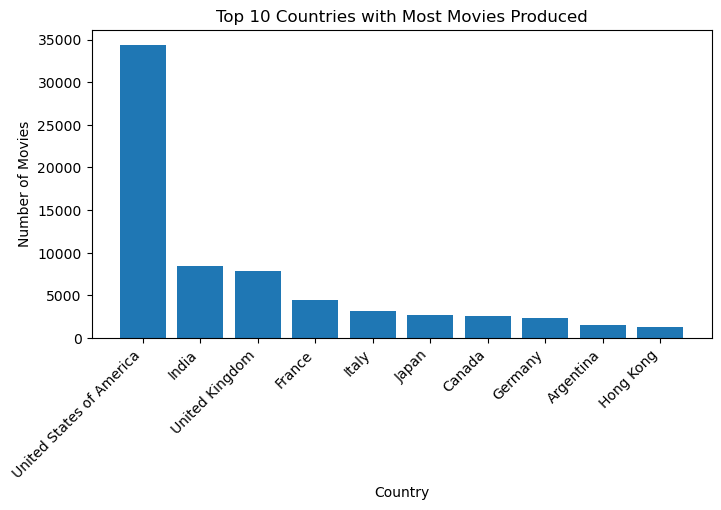

The top 1 production country is United States of America and concerns 39.81% of all movies produced.


In [ ]:
# Compute a box plot of top 10 countries with most movies produced
country_counts = {}

for countries in all_movies['Movie countries']:
    for country in countries:
        if country in country_counts:
            country_counts[country] += 1
        else:
            country_counts[country] = 1

# Get the top 10 countries
top_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top countries
top_countries_df = pd.DataFrame(top_countries, columns=['Country', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_countries_df['Country'], top_countries_df['Count'])
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Top 10 Countries with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 country and its percentage
top_1_country = top_countries_df['Country'].iloc[0]
percentage = country_counts[top_1_country] / sum(country_counts.values()) * 100
print(f'The top 1 production country is {top_1_country} and concerns {percentage:.2f}% of all movies produced.')

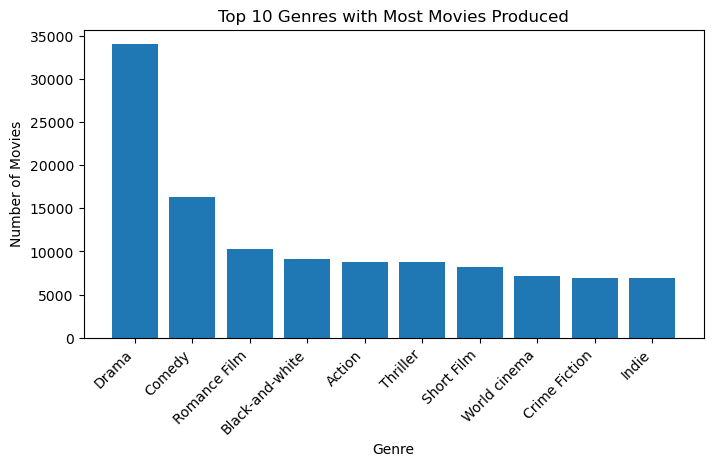

The top 1 genre is Drama and represents 13.98% of all movies produced.


In [ ]:
# Compute a box plot of top 10 genres with most movies produced
genre_counts = {}

for genres in all_movies['Movie genres']:
    for genre in genres:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Get the top 10 genres
top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_genres_df['Genre'], top_genres_df['Count'])
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top 10 Genres with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_genre = top_genres_df['Genre'].iloc[0]
percentage = genre_counts[top_1_genre] / sum(genre_counts.values()) * 100
print(f'The top 1 genre is {top_1_genre} and represents {percentage:.2f}% of all movies produced.')

These results show us that an analysis of the whole dataset will actually be more representative of movies produced or co-produced in the USA and movies belonging to the genre Drama. 

## Missing values plutôt ici => enlever dans partie 1 ??

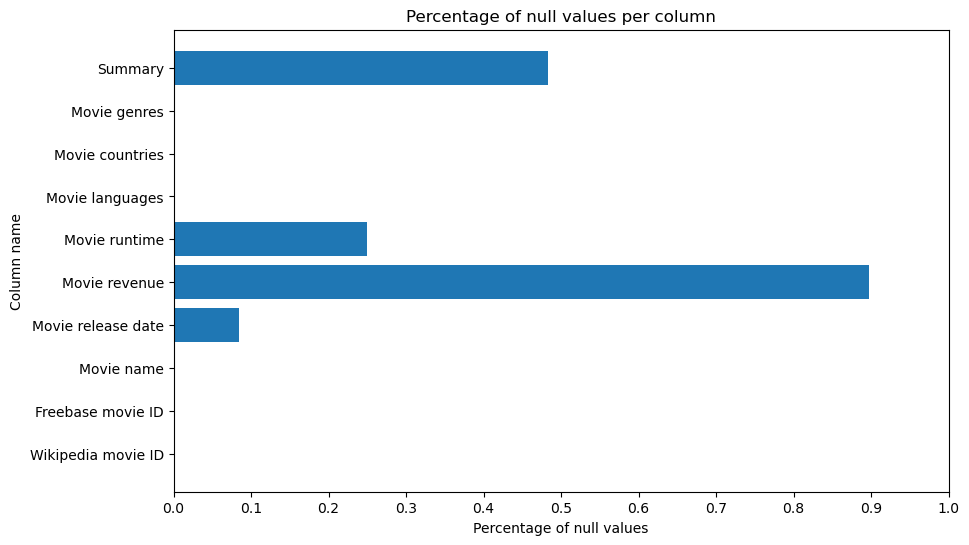

In [ ]:
# plot the percentage of missing values for all columns in the all_movies dataframe
plt.figure(figsize=(10, 6))
plt.barh(all_movies_null.index, all_movies_null['Percentage of null values'])
plt.xlabel('Percentage of null values')
plt.ylabel('Column name')
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.title('Percentage of null values per column')
plt.show()

We see that there are a lot of missing values of the movie revenues (around 90%), we need to find another metric for judging films popularity. IMDb ratings seem to be a good alternative. This dataset contains the average IMDb rating of movies and the number of votes.

# 4. Add IMDb ratings

### Load the data

In [ ]:
movie_ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t', header=0)

In [ ]:
movie_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


### Use Wikidata query to create a table that link IMDb identifier tconst with Freebase ID

Since multiple movies have the same name and appear the same year, we have to link the two dataset using freebase ID of the movies in the original dataset and the unique identifier tconst of the IMDb ratings dataset. We use Wikidata query to create a link table

In [ ]:
# Define a function that uses wikidata queries to link Freebase movie ID and IMDb tconst

def link_tconst_freebaseID():
    url = 'https://query.wikidata.org/sparql'

    # Query to get freebase ID and IMDb ID
    # wdt:P345 IMDb ID in wikidata
    # wdt:P646 Freebase ID in wikidata
    query = """
    SELECT ?item ?tconst ?freebaseID WHERE {
        ?item wdt:P345 ?tconst.
        OPTIONAL {?item wdt:P646 ?freebaseID}
    }
    """

    # Query
    params = {'query': query, 'format': 'json'}
    # headers = {'User-Agent': 'WDQS-example Python/%s.%s' % (sys.version_info[0], sys.version_info[1])}
    data = requests.get(url ,params = params).json()

    # Create a dataframe that link IMDb tconst and freebaseID
    tconst = []
    freebase_id = []
    for item in data['results']['bindings']:
        tconst.append(item['tconst']['value'])
        freebase_id_val = item.get('freebaseID', {}).get('value', np.nan)
        freebase_id.append(freebase_id_val)

    return pd.DataFrame(data={'tconst': tconst, 'Freebase movie ID': freebase_id})


In [ ]:
# Create the table
link_id = link_tconst_freebaseID()

# Drop duplicates
link_id = link_id.drop_duplicates(subset=['tconst'])
link_id = link_id.drop_duplicates(subset=['Freebase movie ID'])

link_id.head()

,tconst,Freebase movie ID
0,nm0010930,/m/0282x
1,nm0124133,/m/09b6zr
2,nm0684496,/m/014d3
3,nm0061667,/m/01rgr
4,tt1675434,/m/0hgqwpj


### Merge the two datasets

In [ ]:
# Add freebase ID to movie_ratings
movie_ratings = pd.merge(movie_ratings, link_id, on='tconst', how='left')
movie_ratings.head()

,tconst,averageRating,numVotes,Freebase movie ID
0,tt0000001,5.7,2006,/m/0kvdsy
1,tt0000002,5.8,269,/m/02pz844
2,tt0000003,6.5,1909,/m/0g53g2
3,tt0000004,5.5,178,/m/02pzdsc
4,tt0000005,6.2,2689,/m/0jq3g


In [ ]:
# Merge all_movies and movie_ratings
all_movies = pd.merge(all_movies, movie_ratings, on='Freebase movie ID', how='left')
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",tt0228333,4.9,56908.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,tt0245916,6.0,69.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,tt0094806,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,tt0094320,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",tt0083949,5.9,623.0


In [ ]:
# Percentage of missing values in the columns averageRatings and num votes
print('Percentage of missing values in averageRatings:', all_movies['averageRating'].isnull().sum() / len(all_movies))
print('Percentage of missing values in numVotes:', all_movies['numVotes'].isnull().sum() / len(all_movies))

Percentage of missing values in averageRatings: 0.17000036701288215
Percentage of missing values in numVotes: 0.17000036701288215


We have far fewer missing values in ratings than in revenues.

### Correlation between movie revenue and average rating

Percentage of movies for which we have both informations:  0.10183384103448698 
 

Person correlation between movie revenue and average rating:  PearsonRResult(statistic=0.16823475825985873, pvalue=6.763377264292565e-54) 
 



c:\Users\colin\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


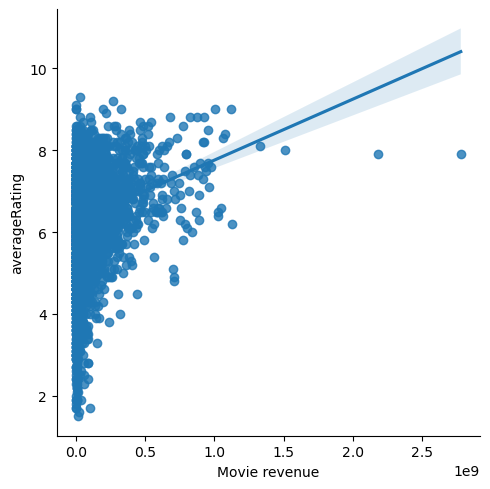

In [ ]:
# Keep movies for which we have both informations
df1 = all_movies.dropna(subset=['Movie revenue', 'averageRating'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: ", len(df1) / len(all_movies), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
print("Person correlation between movie revenue and average rating: ", stats.pearsonr(df1['Movie revenue'], df1['averageRating']), '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='averageRating', data=df1)

There is a significant positive correlation between a movie revenue and its average rating.

### Correlation between movie revenue and number of votes for rating

Percentage of movies for which we have both informations:  0.10183384103448698 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=0.6550136090668378, pvalue=0.0) 
 



c:\Users\colin\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


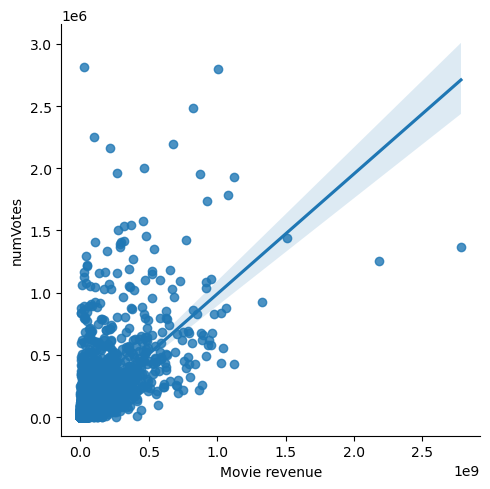

In [ ]:
# Keep movies for which we have both informations
df2 = all_movies.dropna(subset=['Movie revenue', 'numVotes'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: ", len(df2) / len(all_movies), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
print("Person correlation between movie revenue and numVotes: ", stats.pearsonr(df2['Movie revenue'], df2['numVotes']), '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='numVotes', data=df2)

There is a significant positive correlation between a movie revenue and its number of votes.

## Utiliser ces corrélation pour dire que les movies ratings = metric qui va dans le même sens que les revenue ??

# À faire

 - Filtrer les datas: enlever colonnes inutiles??? à demander 
 - Enlever les duplicate complets -> 
 - Drop actor date of birth???? à demander


Partie de romain:
 - sortir % NaN des revenue 